In [27]:
from __future__ import print_function
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from scipy.io import loadmat
import random
import scipy
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import utils
import urllib.request

### Download Dataset

In [ ]:
#folder where you want have your data
folder = "data_"

data_folder = os.path.join(os.getcwd(), folder)
os.makedirs(data_folder, exist_ok=True)

#Download Training Data
urllib.request.urlretrieve('http://imagenet.stanford.edu/internal/car196/cars_train.tgz', filename=os.path.join(data_folder, 'train-images.gz'))

#Download Devkit Data
urllib.request.urlretrieve('https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz', filename=os.path.join(data_folder, 'devkit.gz'))

#extract Data
utils.unzip(os.path.join(data_folder, 'devkit.gz'), data_folder)
utils.unzip(os.path.join(data_folder, 'train-images.gz'), data_folder)

### Load Car Train Dataset

In [28]:

carstrain_folder = "data/cars_train/" #Folder where images are located
car_annotations_path = "data/devkit/cars_train_annos.mat" # training annotation mat file location
car_metadata_path = "data/devkit/cars_meta.mat" #meta data mat file location

annotations = loadmat(car_annotations_path)
meta = loadmat(car_metadata_path)
meta = np.concatenate(meta["class_names"][0])

dataset = []
columns = ["x1", "y1", "x2", "y2", "class ID", "Model","Image name"]
for example in annotations["annotations"][0]:
    
    filename = example[-1][0]
    annos = np.concatenate(list(example)[:-1]).ravel().tolist()
    carmodel = meta[example[-2][0] - 1][0]
    dataset.append(annos + [carmodel] + [filename])
    
dataset = pd.DataFrame(dataset, columns=columns)

In [29]:
dataset.head()

,x1,y1,x2,y2,class ID,Model,Image name
0,39,116,569,375,14,Audi TTS Coupe 2012,00001.jpg
1,36,116,868,587,3,Acura TL Sedan 2012,00002.jpg
2,85,109,601,381,91,Dodge Dakota Club Cab 2007,00003.jpg
3,621,393,1484,1096,134,Hyundai Sonata Hybrid Sedan 2012,00004.jpg
4,14,36,133,99,106,Ford F-450 Super Duty Crew Cab 2012,00005.jpg


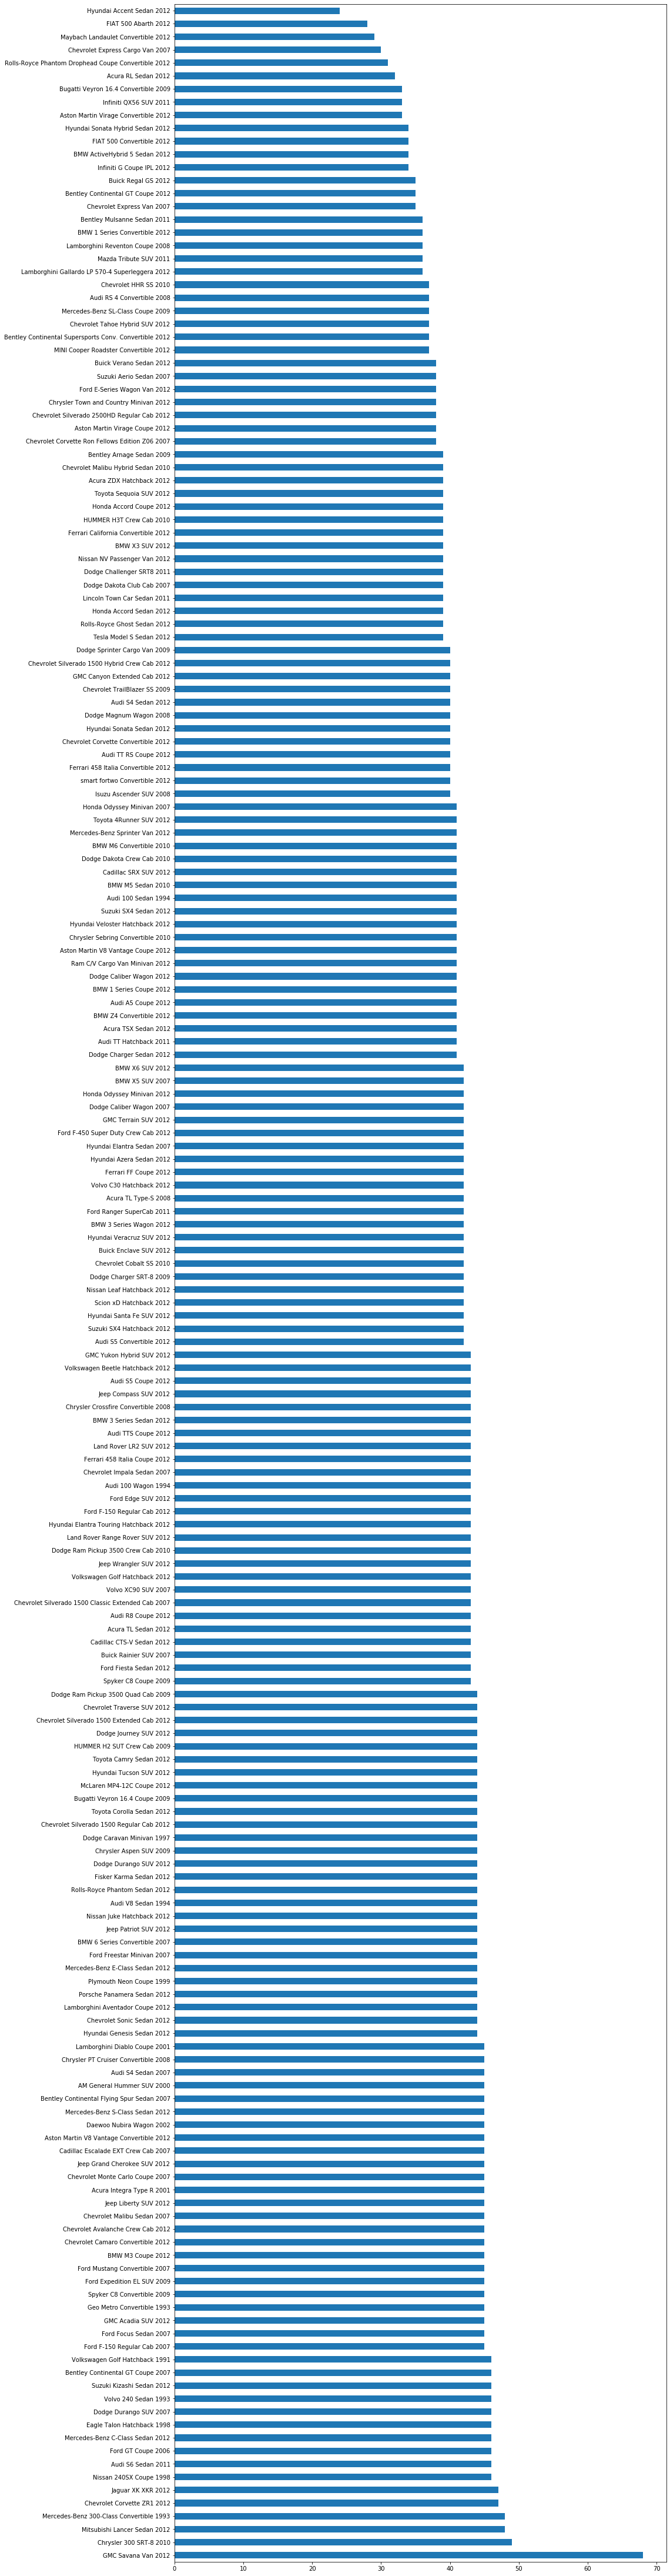

In [30]:
#CHECK DATASET CLASSES
dataset["Model"].value_counts().plot.barh(figsize=(15,80))

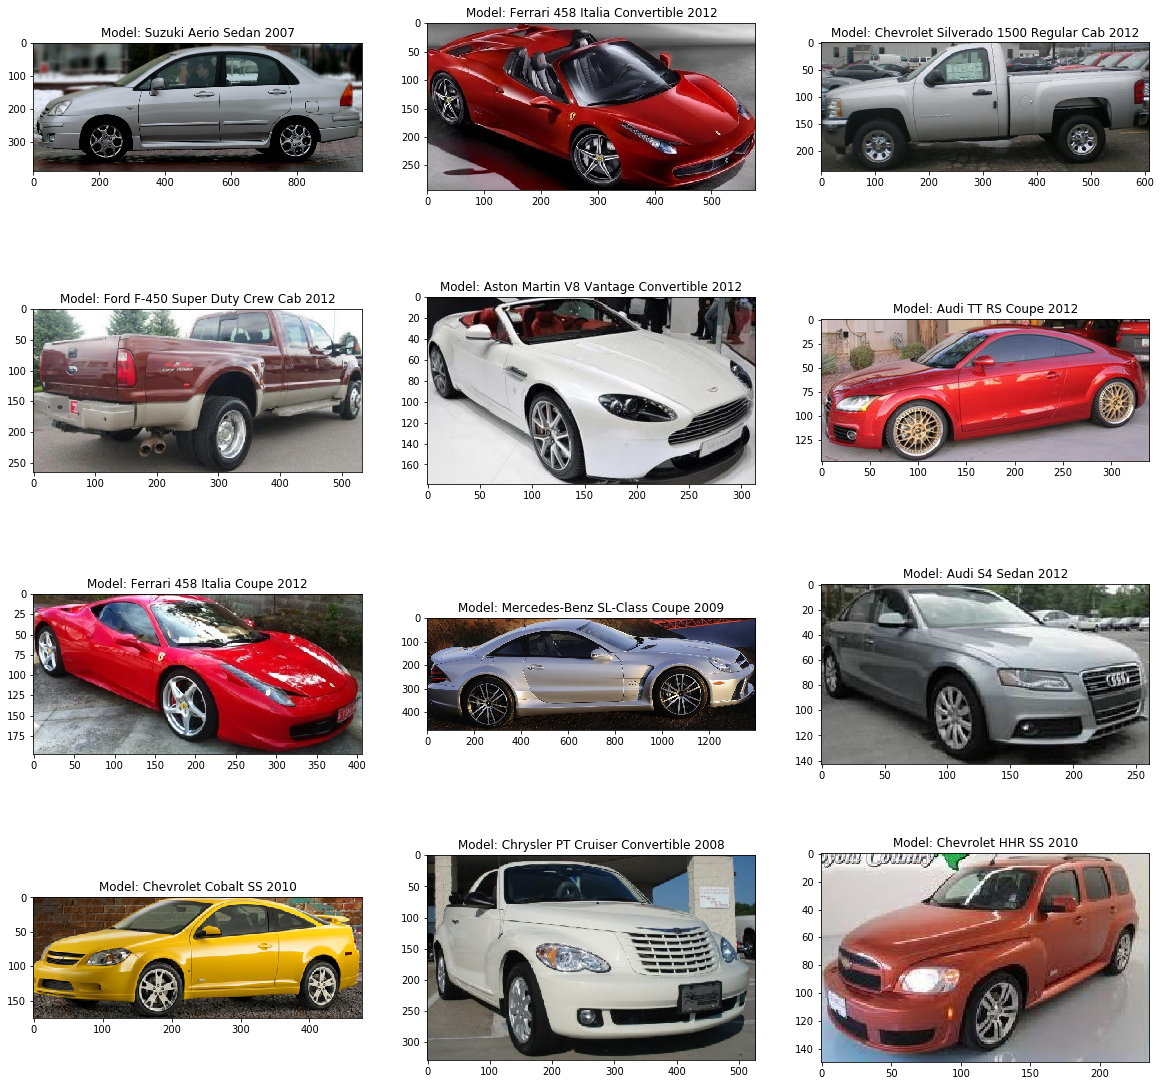

In [31]:
#Quick Sanity Check
fig = plt.figure(figsize=(20,20))
for i in range(1,13):
    plt.subplot(4,3,i)
    
    idx = random.randint(0, annotations["annotations"].shape[1]-1)
    
    image = mpimg.imread(os.path.join(carstrain_folder, dataset.iloc[idx]["Image name"]))
    plt.imshow(image[dataset.iloc[idx]["y1"]: dataset.iloc[idx]["y2"], dataset.iloc[idx]["x1"] : dataset.iloc[idx]["x2"]])
    plt.title("Model: {}".format(dataset.iloc[idx]["Model"]))

plt.show()

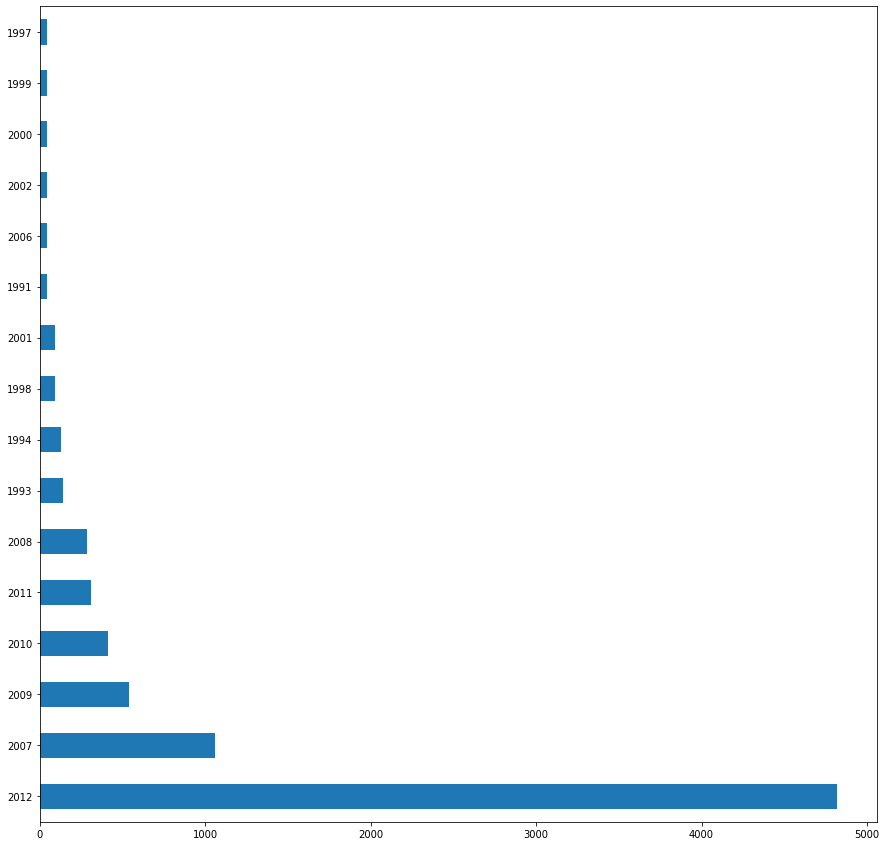

In [32]:
#Check Year Distribution of CARS
years, yearsID = utils.get_Year(dataset["Model"].values)
pd.Series(years).value_counts().plot.barh(figsize=(15,15))

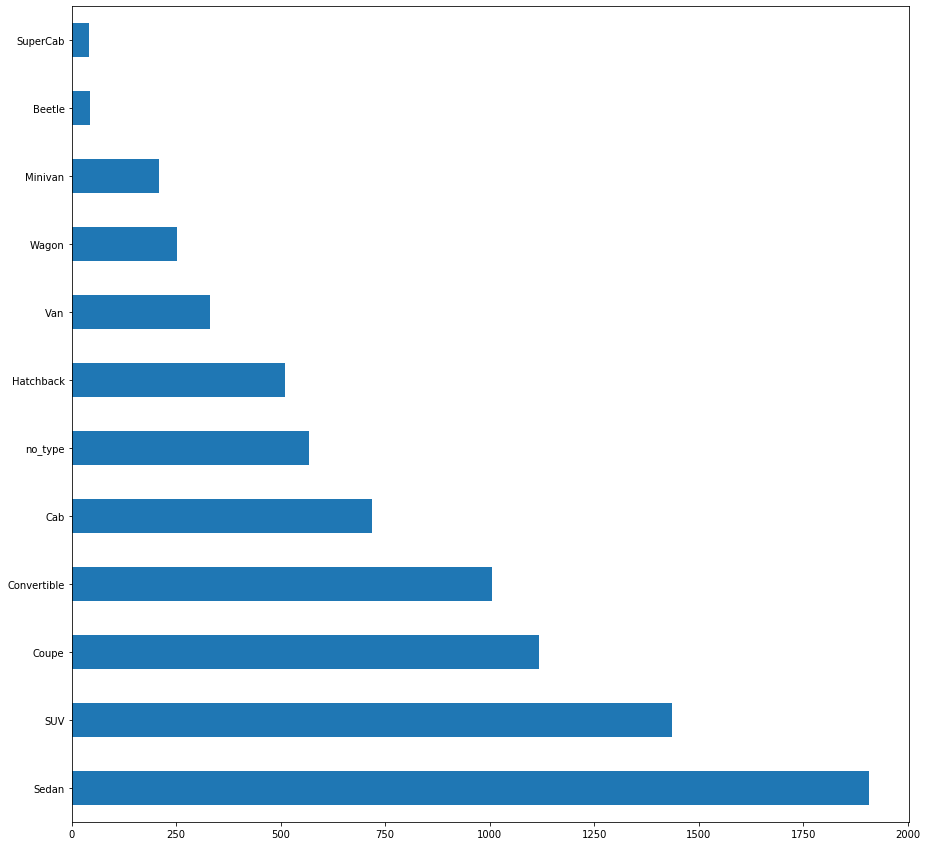

In [37]:
#Check Year Distribution of CARS
type_, typeID = utils.get_Type(dataset["Model"].values)
pd.Series(type_).value_counts().plot.barh(figsize=(15,15))

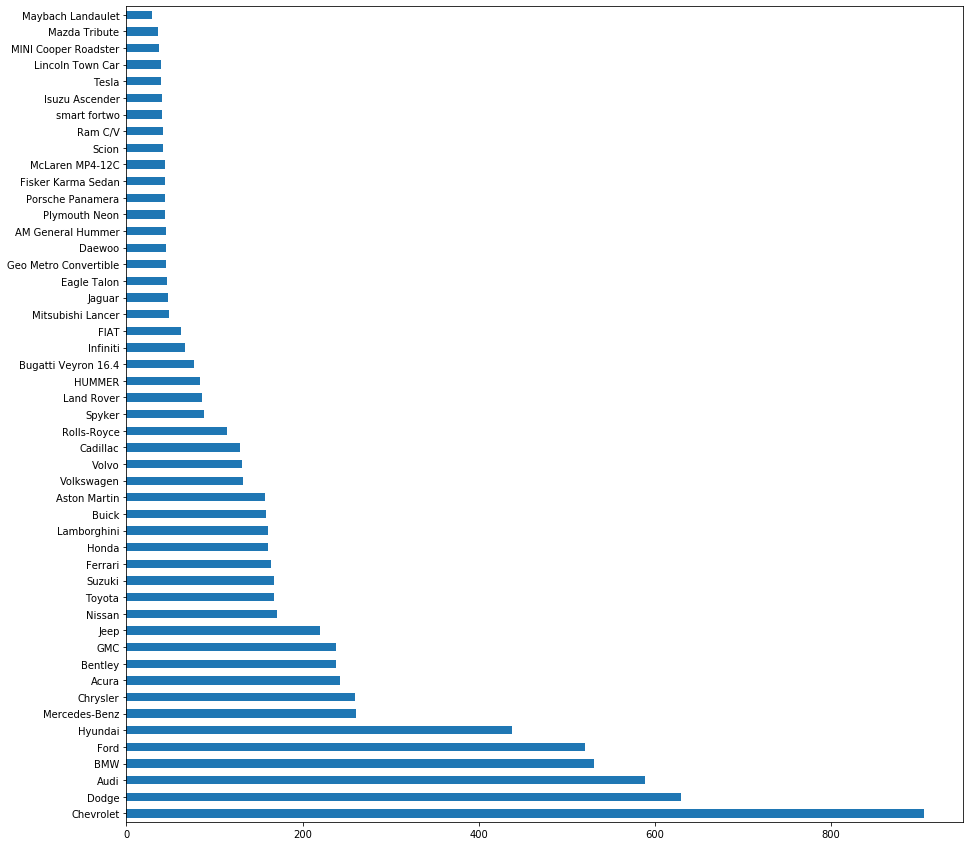

In [34]:
#Check Year Distribution of CARS
years, yearsID = utils.get_Maker(dataset["Model"].values)
pd.Series(years).value_counts().plot.barh(figsize=(15,15))

In [15]:
#Image Normalization
from PIL import Image
mean = []
var = []
for idx, file_name in enumerate(dataset["Image name"]):
    img_path = os.path.join(carstrain_folder, file_name)
    img = Image.open(img_path)
    img = np.asarray(img.convert("RGB"))
    
    Rchan = img[:,:,0]  # Red color channel
    Gchan = img[:,:,1]  # Green color channel
    Bchan = img[:,:,2]  # Blue color channel

    Rchan_mean = Rchan.mean()
    Gchan_mean = Gchan.mean()
    Bchan_mean = Bchan.mean()
    
    Rchan_var = Rchan.var()
    Gchan_var = Gchan.var()
    Bchan_var = Bchan.var()
    
    mean.append([Rchan_mean, Gchan_mean, Bchan_mean])
    var.append([Rchan_var, Gchan_var, Bchan_var])

In [ ]:
#Feature Selection 
#Calculating Cosine Similarity
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

pic_one = str(input("Input first image name\n"))
pic_two = str(input("Input second image name\n"))

# Load the pretrained model
model = models.resnet18(pretrained=True)
# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def vector_conversion(image_name):
    
    img = Image.open(image_name)
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))

    my_embedding = torch.zeros(512)

    def copy_data(m, i, o):
        my_embedding.copy_(o.data)

    h = layer.register_forward_hook(copy_data)

    model(t_img)

    h.remove()

    return my_embedding

In [38]:
dataset["type"] = type_

In [ ]:
#Tsne Plot
X = []
y = dataset["type"].values

for idx, val in enumerate(dataset[["type", "Image name"]].values):
    img = mpimg.imread(os.path.join(carstrain_folder, val[1]))
    flatten_img = list(cv2.resize(img[dataset.iloc[idx]["y1"]: dataset.iloc[idx]["y2"], dataset.iloc[idx]["x1"] : dataset.iloc[idx]["x2"]], (224,224)).flatten()/255)
    X.append(flatten_img)
    if idx % 1000 == 0:
        print("{} images done".format(idx))
        
df=pd.DataFrame(X)
df["Y"] = y

#Visualize the Different 
# For reproducability of the results
np.random.seed(42)
N =2000
rndperm = np.random.permutation(df.shape[0])

df_subset = df.loc[rndperm[:N],:].copy()
df_subset.dropna(inplace=True)
data_subset = df_subset.drop(columns=["Y"]).values


tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=10000)
tsne_results = tsne.fit_transform(data_subset)

0 images done
1000 images done
